In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import  List, Union, Type, Callable

%matplotlib inline

BIG_SEED = 132 #random seed for later

In [2]:
df = pd.read_csv('data.csv')

In [3]:
print(len(df))
df.head()

100


,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,2
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,2


In [4]:
#This way the rare class has value 1 (for the F-score)
df.Class = df.Class - 1

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter,\
                                        UniformIntegerHyperparameter

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO #Random Forest
from smac.facade.smac_bo_facade import SMAC4BO   #Bayesian
#from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer import acquisition

In [6]:
#SMAC needs a Configuration Space where it will search for the hyperparameters
cs = ConfigurationSpace()

#define the domain of each hyperparameter
lr = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9)

#add the hyperparameters to the configuration space
cs.add_hyperparameters([lr, momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

In [7]:
def MLP_score_1(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    rseed = int(conf['momentum']*conf['learning_rate_init']*5000)
    MLPclf = MLPClassifier(hidden_layer_sizes=(4,2,), momentum = conf['momentum'],
                          learning_rate_init = conf['learning_rate_init'],
                          random_state=rseed)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring='f1')
    #print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    #scores = cross_validate(MLPclf, X, y, cv=10, scoring=['accuracy','f1', 'recall', 'precision'])
    #print(conf['learning_rate_init'], conf['momentum'], np.mean(scores['test_f1']), 
    #      np.mean(scores['test_recall']), np.mean(scores['test_precision']), np.mean(scores['test_accuracy']))
    return 1 - np.mean(score)  # it needs to Minimize it!

In [8]:
scenario = Scenario(scenario={"run_obj": "quality",   # we optimize quality
                              "runcount-limit": 25,   # number iterations
                              "cs": cs,               # configuration space
                              "output_dir": "logs",    # create a log folder named 'logs'
                              "deterministic": "true"})

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs


In [9]:
#create 5 random configuration, will be used in the optimizer
cs.seed(BIG_SEED)
init = cs.sample_configuration(5)
cs.seed(None)

In [10]:
smac_LCB = SMAC4BO(scenario=scenario, tae_runner=MLP_score_1, 
                   rng=np.random.RandomState(BIG_SEED),
                   initial_design=None, 
                   initial_design_kwargs={'max_config_fracs':5/25},
                   initial_configurations=init, 
                   acquisition_function=acquisition.LCB)

/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


In [11]:
result_LCB = smac_LCB.optimize()

INFO:smac.intensification.intensification.Intensifier:Challenger (0.9333) is better than incumbent (0.9500) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.08028135089132196 -> 0.04430300876374074
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.38552141981754795 -> 0.8696975470069911
INFO:smac.intensification.intensification.Intensifier:Challenger (0.8933) is better than incumbent (0.9333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.04430300876374074 -> 0.0845773877536592
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8696975470069911 -> 0.3849918837749665
INFO:smac.intensification.intensification.Intensifier:Challenger (0.7833) is better than incumbent (0.8933) on 1 runs.
INFO:smac.intensification.intensifi

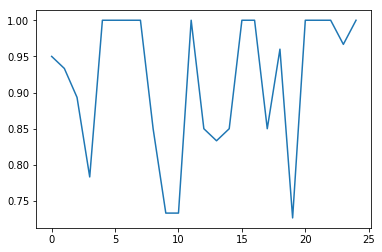

In [12]:
plt.plot(smac_LCB.get_X_y()[1])

In [13]:
smac_EI = SMAC4BO(scenario=scenario, tae_runner=MLP_score_1, 
                  rng=np.random.RandomState(BIG_SEED),
                  #initial_design=RandomConfigurations, 
                  #initial_design_kwargs={'rng':np.random.RandomState(2) ,'max_config_fracs':5/25},
                  initial_design=None,
                  initial_design_kwargs={'max_config_fracs':5/25},
                  initial_configurations=init, 
                  acquisition_function=acquisition.EI)

INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


In [14]:
print('lr', 'momentum', 'f1', 'recall', 'precision')
result_EI = smac_EI.optimize()

lr momentum f1 recall precision


INFO:smac.intensification.intensification.Intensifier:Challenger (0.9333) is better than incumbent (0.9500) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.08028135089132196 -> 0.04430300876374074
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.38552141981754795 -> 0.8696975470069911
INFO:smac.intensification.intensification.Intensifier:Challenger (0.8933) is better than incumbent (0.9333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.04430300876374074 -> 0.0845773877536592
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8696975470069911 -> 0.3849918837749665
INFO:smac.intensification.intensification.Intensifier:Challenger (0.7833) is better than incumbent (0.8933) on 1 runs.
INFO:smac.intensification.intensifi

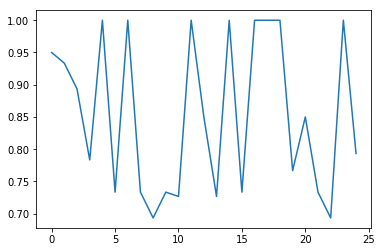

In [15]:
plt.plot(smac_EI.get_X_y()[1])

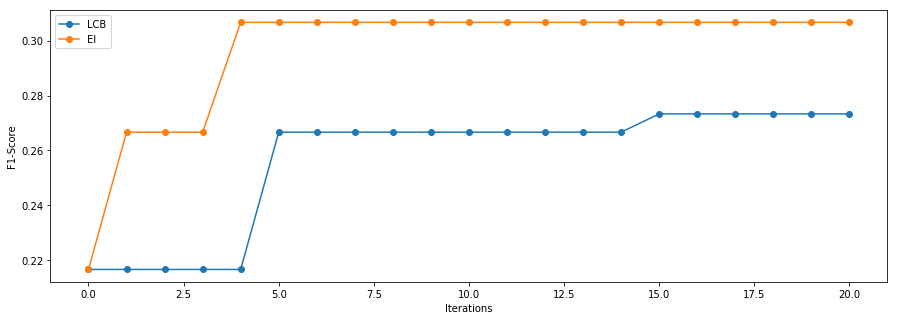

In [16]:
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_LCB.get_X_y()[1])[4:], 'o-') #0,1,2,3,4 sono i punti iniziali
plt.plot(1-np.minimum.accumulate(smac_EI.get_X_y()[1])[4:], 'o-')
plt.legend(['LCB','EI'])
plt.ylabel('F1-Score')
plt.xlabel('Iterations')
plt.show()